# OSMnx

Testing the [OSMnx](https://geoffboeing.com/2016/11/osmnx-python-street-networks/) library for loading and processing OSM data.

See these [notebooks](https://github.com/gboeing/osmnx-examples/tree/master/notebooks) for examples of using the library.

In [ ]:
# !brew install spatialindex

In [10]:
import osmnx as ox
import glob

%matplotlib inline
ox.config(log_console=True, use_cache=True, data_folder='')
ox.__version__

'0.10'

In [11]:
graphml_fnames = glob.glob('data/boeing_dataverse/06-CA-cities-street_networks-graphml/*.graphml')

graphml_fnames = graphml_fnames[:3]

graphml_fnames

['data/boeing_dataverse/06-CA-cities-street_networks-graphml/0639710_Lakeport.graphml',
 'data/boeing_dataverse/06-CA-cities-street_networks-graphml/0602042_Anderson.graphml',
 'data/boeing_dataverse/06-CA-cities-street_networks-graphml/0657456_Pittsburg.graphml']

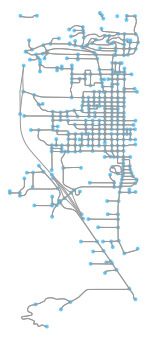

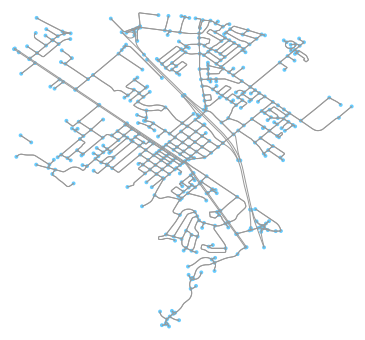

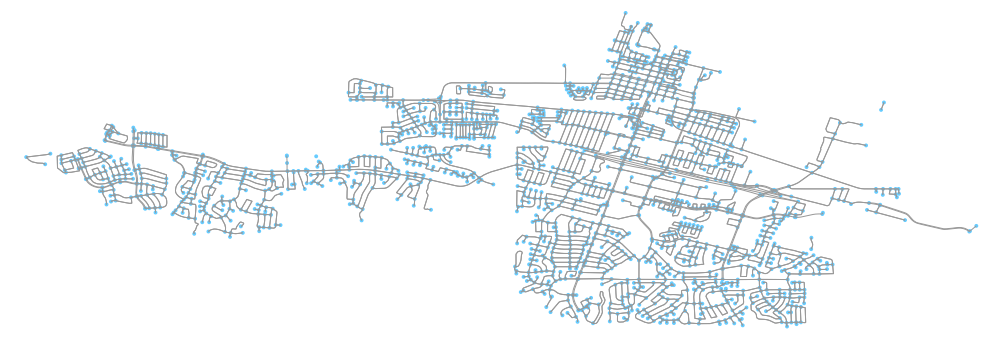

In [12]:
for fname in graphml_fnames:
    G = ox.load_graphml(fname)
    fig, ax = ox.plot_graph(G)

In [4]:
!pwd

/Users/ischeinfeld/Documents/Stanford/y4/q1/cs224w/project/streets


In [14]:
ox.load_graphml('boeing_dataverse/06-CA-cities-street_networks-graphml/0639710_Lakeport.graphml')